Epoch [500/5000], Loss: 0.0002
Epoch [1000/5000], Loss: 0.0002
Epoch [1500/5000], Loss: 0.0002
Epoch [2000/5000], Loss: 0.0001
Epoch [2500/5000], Loss: 0.0001
Epoch [3000/5000], Loss: 0.0002
Epoch [3500/5000], Loss: 0.0001
Epoch [4000/5000], Loss: 0.0001
Epoch [4500/5000], Loss: 0.0001
Epoch [5000/5000], Loss: 0.0001


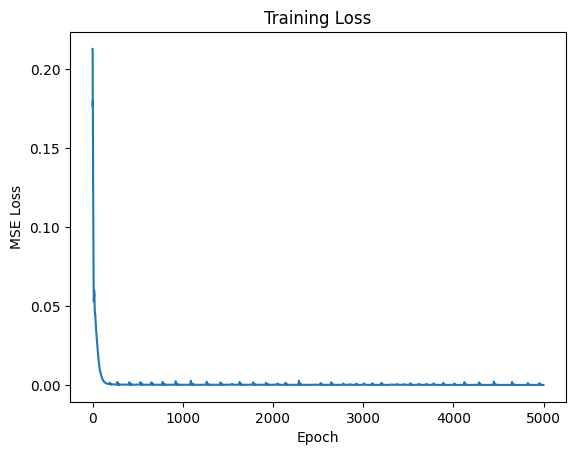

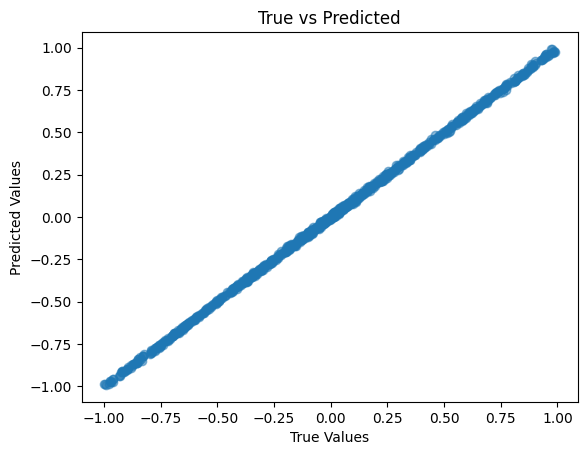

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Kolmogorov-Arnold Network module
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_q=None):
        """
        input_dim: number of input dimensions (n)
        hidden_dim: size of hidden layers in the one-dimensional sub-networks
        num_q: number of outer functions; by default, 2*n + 1 as in the theorem
        """
        super(KolmogorovArnoldNetwork, self).__init__()
        self.input_dim = input_dim
        self.num_q = num_q if num_q is not None else 2 * input_dim + 1
        
        # Create a list of "phi" networks: these act on the aggregated one-dimensional representations.
        self.phi_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            ) for _ in range(self.num_q)
        ])
        
        # Create a list (for each q) of lists (for each input dimension) of "psi" networks.
        self.psi_layers = nn.ModuleList([
            nn.ModuleList([
                nn.Sequential(
                    nn.Linear(1, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 1)
                ) for _ in range(input_dim)
            ]) for _ in range(self.num_q)
        ])
        
    def forward(self, x):
        """
        x: input tensor of shape (batch_size, input_dim)
        returns: approximated function output (batch_size, 1)
        """
        out = 0
        # Loop over each outer function index q
        for q in range(self.num_q):
            # For each q, compute S_q = sum_{p=1}^{input_dim} psi_{pq}(x_p)
            S_q = 0
            for p in range(self.input_dim):
                # x[:, p] has shape (batch_size,); reshape to (batch_size, 1)
                xp = x[:, p].unsqueeze(1)
                S_q = S_q + self.psi_layers[q][p](xp)
            # Apply the phi network to S_q and accumulate the result
            out = out + self.phi_layers[q](S_q)
        return out

# Define the target function we wish to approximate: f(x,y) = sin(pi*x) * cos(pi*y)
def target_function(x):
    # x is expected to have shape (batch_size, 2)
    return torch.sin(np.pi * x[:, 0:1]) * torch.cos(np.pi * x[:, 1:2])

# Generate toy dataset
np.random.seed(42)
torch.manual_seed(42)
num_samples = 1000
x_data = np.random.rand(num_samples, 2)  # Two-dimensional inputs in [0, 1]
y_data = np.sin(np.pi * x_data[:, 0:1]) * np.cos(np.pi * x_data[:, 1:2])

x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)

# Instantiate the Kolmogorov-Arnold Network
input_dim = 2
hidden_dim = 16  # You can experiment with this size
model = KolmogorovArnoldNetwork(input_dim, hidden_dim)

# Set up loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot training loss over epochs
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

# Evaluate and visualize the learned function
model.eval()
with torch.no_grad():
    y_pred = model(x_tensor)
plt.figure()
plt.scatter(y_tensor.numpy(), y_pred.numpy(), alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")
plt.show()